In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential, save_model, load_model
from keras.layers import Embedding, Dense, LSTM, Bidirectional
from keras.optimizers import Nadam
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint, History
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import re
import pickle

#!pip install PyPDF2==1.26.0
from PyPDF2 import PdfFileWriter, PdfFileReader

In [22]:
## HELPER FUNCTIONS ##

SEQUENCE_LENGTH = 21   # 20 words in sentence, model predict 21st
SENTENCE_LENGTH_ERROR_MESSAGE = "The sentence cannot be empty"
TEXT_LENGTH_ERROR_MESSAGE = "The length of generated text must be an integer larger than 0"

def plot_training_history(training_history:History):
  """
  Plots training history of the model on two separate plots with data about: training accuracy and training loss

  :param training_history: callbacks.History object, history of the model training
  """
  history = training_history.history
  train_acc, train_loss = history['accuracy'], history['loss']
  nb_epochs = len(train_acc)            # number of epochs 

  fig, (acc_plot, loss_plot) = plt.subplots(1,2, figsize=(12,6))

  acc_plot.plot(list(range(nb_epochs)), train_acc, 'orange') 
  acc_plot.grid()
  acc_plot.title.set_text('Training accuracy')
  acc_plot.set_xlabel('Epochs')
  acc_plot.set_ylabel('Accuracy')

  loss_plot.plot(list(range(nb_epochs)), train_loss, 'blue') 
  loss_plot.grid()
  loss_plot.title.set_text('Training loss')
  loss_plot.set_xlabel('Epochs')
  loss_plot.set_ylabel('Loss')


def generate_text(model:Sequential, tokenizer:Tokenizer, sentence = None, text_length = 20) -> str:
  """
  Generates text using given model

  :param model: Sequential object, the trained RNN model
  :param tokenizer: Tokenizer object holding the set of all words on which the model was learned 
  :param sentence: str, random sentence that will be fed to the model as a start of the further generated text. If None, user will be asked to input the starting sentence.
  :param text_length: int, number of words to generate, must be greater than 0. 
  """
  if not sentence:
    sentence = input('Type in your sentence: ').lower()

  assert len(start_sentence.strip()) > 1, SENTENCE_LENGTH_ERROR_MESSAGE
  assert text_length > 0, TEXT_LENGTH_ERROR_MESSAGE

  for _ in range(text_length):
    digit_sentence = np.array(tokenizer.texts_to_sequences([sentence]))
    padded = pad_sequences(digit_sentence, maxlen = SEQUENCE_LENGTH - 1, padding = 'pre')

    # index of the predicted (most possible) next word in tokenizer vocabulary set
    predicted_word = np.argmax(model.predict(padded))

    # appending the predicted word to the sentence
    sentence += "{} ".format(tokenizer.index_word[predicted_word])

  print(sentence.capitalize())

# Importing and preprocessing the data

RNNs or Recurrent Neural Networks designed to perform NLP (Natural Language Processing) tasks need properly prepared data to achieve high results:
- appropriate amount of input data (sentences in this case),
- removed punctuation, numbers and other redundant staff from the sentences
- arranging sentences into sequences of the appropriate length, as well as words to be predicted
- tokenizing the sentences, i.e. changing the words from the text into numeric form

In [16]:
origin_pdf = PdfFileReader('The Complete Works of H.P. Lovecraft.pdf', 'rb')

START_PAGE = 4  # omit the first pages with cover and table of contents
END_PAGE = 203  # first 37 stories

original_text = ''

for i in range(START_PAGE, END_PAGE):
    page_content = origin_pdf.getPage(i).extractText()
    original_text += page_content

In [17]:
# regex pattern, containing the names of the stories, along with the year they were written, as well as punctuation marks and remaining numbers 
pattern = r'([A-Za-z]* [A-Za-z]*\n \n\([0-9]{4}\)|[0123456789#".,_?!:;\n\t]|Return to Table of Contents)'

text = re.sub(pattern, '', original_text).lower()
all_words = list(map(lambda word: word.upper() if word == 'i' else word, text.split()))

In [18]:
SEQUENCE_LENGTH = 21   # 20 words in sentence, model predict 21st

text_sequences = []

for i in range(SEQUENCE_LENGTH, len(all_words)):
  sequence = all_words[i - SEQUENCE_LENGTH:i]

  text_sequences.append(sequence)

In [35]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)  

digit_sequences = np.array(tokenizer.texts_to_sequences(text_sequences)) # changing the words into numeric representation

# serializing the tokenizer object for later use
with open('tokenizer.pickle', 'wb') as file:
    pickle.dump(tokenizer, file)

In [36]:
# removing the unecessary variables in order to free memory
del all_words
del text
del original_text
del text_sequences

In [37]:
# number of all unique words in the text
VOCAB_SIZE = len(tokenizer.word_counts) + 1

In [38]:
VOCAB_SIZE

12557

In [39]:
# our X and y data
sequences = digit_sequences[:,:-1]
next_words = to_categorical(digit_sequences[:,-1])

sequences, next_words = shuffle(sequences, next_words)

In [40]:
sequences.shape

(115224, 20)

# Building the RNN

In [41]:
def lr_schedule(epoch, lr):
    """ Callback for the LearningRateScheduler class. Reduces lr every 60 rounds. """
    
  reduce_factor = 0.8  

  if epoch > 1 and epoch % 60 == 0 and lr*reduce_factor >= 0.001: 
    return lr*reduce_factor

  return lr


BATCH_SIZE = 128
EPOCHS = 150
LEARNING_RATE = 0.003
OPTIMIZER = Nadam(LEARNING_RATE)
CALLBACKS = [EarlyStopping(monitor = 'accuracy', mode = 'max', patience=5, restore_best_weights=True, verbose=1),
             LearningRateScheduler(lr_schedule),
             ModelCheckpoint('model.h5', monitor = 'accuracy', mode= 'max', save_best_only=True)]


model = Sequential([
          Embedding(VOCAB_SIZE, SEQUENCE_LENGTH - 1, input_length = SEQUENCE_LENGTH - 1),
          Bidirectional(LSTM(128, return_sequences = True)),
          Bidirectional(LSTM(256)),
          Dense(units = 128, activation = 'relu'),
          Dense(units = VOCAB_SIZE, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 20)            251140    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           152576    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1050624   
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 12557)             1619853   
Total params: 3,139,857
Trainable params: 3,139,857
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.compile(optimizer = OPTIMIZER, loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(sequences, next_words,
          batch_size = BATCH_SIZE,
          epochs = EPOCHS,
          callbacks = CALLBACKS)

Epoch 1/150
901/901 [==============================] - 61s 27ms/step - loss: 7.0510 - accuracy: 0.0824
Epoch 2/150
901/901 [==============================] - 25s 27ms/step - loss: 6.2568 - accuracy: 0.1241
Epoch 3/150
901/901 [==============================] - 24s 27ms/step - loss: 5.9670 - accuracy: 0.1383
Epoch 4/150
901/901 [==============================] - 24s 27ms/step - loss: 5.7567 - accuracy: 0.1480
Epoch 5/150
901/901 [==============================] - 24s 27ms/step - loss: 5.5566 - accuracy: 0.1574
Epoch 6/150
901/901 [==============================] - 24s 27ms/step - loss: 5.3621 - accuracy: 0.1669
Epoch 7/150
901/901 [==============================] - 24s 27ms/step - loss: 5.2177 - accuracy: 0.1726
Epoch 8/150
901/901 [==============================] - 25s 27ms/step - loss: 5.0141 - accuracy: 0.1848
Epoch 9/150
901/901 [==============================] - 24s 27ms/step - loss: 4.8358 - accuracy: 0.1923
Epoch 10/150
901/901 [==============================] - 24s 26ms/step - l

In [ ]:
save_model(model, 'model95.h5')

# Visualizing the training

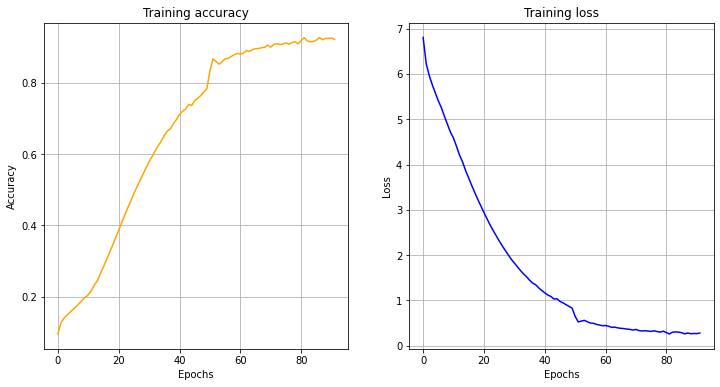

In [43]:
plot_training_history(history)

# Generating the text

The final part of the project where we can finally test the capabilities of the trained model. As we can see, the generated text is not entirely consistent due to the lack of punctuation marks, but the created sentences have a kind of Lovecraft writing style, which was expected the most

In [11]:
model = load_model('model.h5', compile = False)
with open(r'tokenizer.pickle', 'rb') as file:
    tokenizer = pickle.load(file)

In [28]:
# Generating text with the provided starting sentence

start_sentence = 'Only two of the prisoners were found sane enough '
generate_text(model, tokenizer, start_sentence, text_length = 45)

Only two of the prisoners were found sane enough to rattle in that picture without apparent volition when a nameless thing had lain or different horror for a night of resentfully a voice of whiskers his wild mask and a large hope to scatter and up the cosmic creaking vision of the altar around 


In [31]:
# Generating text with user's input sentence

generate_text(model, tokenizer, text_length = 48)

Type in your sentence: despite a natural loathing he followed the creature into a 
Despite a natural loathing he followed the creature into a pitch and unknown burst on the ongas through the nearest side of the mansion its weird hair ib were reflecting hideous terrible like the stairs it must have been a silent and deserted world from beyond the accursed night of little shafts care to the shores of old 
